### How can we increase the average rating of the accommodations in Madrid to 95% while keeping the revenue as high as possible ?

In [38]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import folium
from folium.plugins import MarkerCluster # for clustering the markers

In [52]:
data = pd.read_csv('db/airbnb.csv')
def price_to_float(x):
    x = x.strip('$')
    x = x.replace(',','_')
    x = float(x)
    return x
data['price'] = data.price.apply(price_to_float)
def tf_to_10(x):
    if x == 't':
        return 1
    elif x == 'f' :
        return 0
    else :
        return x
data['host_is_superhost'] = data.host_is_superhost.apply(tf_to_10)
data['host_has_profile_pic'] = data.host_has_profile_pic.apply(tf_to_10)
data['host_identity_verified'] = data.host_identity_verified.apply(tf_to_10)
def percent_to_num(x):
    if isinstance(x, float):
        x = np.nan
    else :
        x = x.strip('%')
        x = int(x)
    return x
data['host_response_rate'] = data.host_response_rate.apply(percent_to_num)
data['host_acceptance_rate'] = data.host_acceptance_rate.apply(percent_to_num)
def cat_response_time(x):
    if isinstance(x, float):
        x = np.nan
    elif x == 'within an hour' :
        x = 1
    elif x == 'within a few hours':
        x = 12
    elif x == 'within a day' :
        x = 24
    elif x == 'a few days or more':
        x = 72
    return x
data['host_response_time'] = data.host_response_time.apply(cat_response_time)
data['revenus'] = data.price * data.yearly_availability*0.6*0.05
def change_since(x):
    x = x.days
    return x
test = pd.to_datetime(data.host_since)
data['host_since_days'] = -(test-pd.to_datetime("2022-05-01"))
data['host_since_days'] = data.host_since_days.apply(change_since)

In [29]:
data.head(5).T

,0,1,2,3,4
id,6369,21853,23001,26825,28200
price,60.0,31.0,50.0,26.0,85.0
neighbourhood,Hispanoamérica,Cármenes,Legazpi,Legazpi,Legazpi
neighbourhood_group,Chamartín,Latina,Arganzuela,Arganzuela,Arganzuela
bedrooms,1.0,1.0,3.0,1.0,3.0
beds,1.0,1.0,5.0,1.0,4.0
accommodates,2,1,6,1,6
amenities,"[""Kitchen"", ""Elevator"", ""Extra pillows and bla...","[""Bed linens"", ""Refrigerator"", ""Dishes and sil...","[""Pool"", ""Dishwasher"", ""Bed linens"", ""Refriger...","[""Elevator"", ""Patio or balcony"", ""Bed linens"",...","[""TV with standard cable"", ""Kitchen"", ""Elevato..."
minimum_nights,1,4,15,2,1
maximum_nights,1125,40,730,1125,365


In [33]:
lat = data.latitude.median()
long = data.longitude.median()
map = folium.Map(location=[lat, long], default_zoom_start=15)

In [35]:
marker_cluster = MarkerCluster().add_to(map) # create marker clusters
for i in range(data.shape[0]):
    location = [data['latitude'][i],data['longitude'][i]]
    folium.Marker(location, # adding more details to the popup screen using HTML
                  popup="""
                  <i>Night price: </i> <br> <b>${}</b> <br> 
                  <i>Number of bedrooms: </i><b><br>{}</b><br>
                  <i>Neighbourhood: </i><b><br>{}</b><br>""".format(
                    round(data['price'][i],2), 
                    round(data['bedrooms'][i]), 
                    data['neighbourhood'][i])).add_to(marker_cluster)

### Which impact on rating reviews ?

* Too much disponibilities *decrease* the rating
* Good impact of 'Superhost' to *increase* the rating
* Lower mean number of person by room *increase* the rating

### What actions ?

* Decrease host_acceptance_rate and yearly_availability just a little to increase quality and the rarity
* Increase the number of Superhost
* Increase the number of bedroom or decrease accommodates - the number of persons

### Ordinary Least Squares Regression

In [53]:
model = smf.ols(formula = """review_scores_rating ~ bedrooms + accommodates + 
+ host_response_time + host_response_rate + 
host_acceptance_rate + host_is_superhost + 
number_of_reviews + yearly_availability + revenus + host_since_days""", data = data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     review_scores_rating   R-squared:                       0.103
Model:                              OLS   Adj. R-squared:                  0.102
Method:                   Least Squares   F-statistic:                     74.37
Date:                  Tue, 28 Sep 2021   Prob (F-statistic):          7.21e-145
Time:                          17:46:26   Log-Likelihood:                -23776.
No. Observations:                  6474   AIC:                         4.757e+04
Df Residuals:                      6463   BIC:                         4.765e+04
Df Model:                            10                                         
Covariance Type:              nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               83.5785      1.400     59.691      0.000      80.834      86.323
bedrooms                 0.5769      0.195      2.957      0.003       0.194       0.959
accommodates            -0.3130      0.077     -4.061      0.000      -0.464      -0.162
host_response_time       0.0530      0.015      3.439      0.001       0.023       0.083
host_response_rate       0.0810      0.012      6.570      0.000       0.057       0.105
host_acceptance_rate    -0.0186      0.005     -3.394      0.001      -0.029      -0.008
host_is_superhost        5.5759      0.260     21.487      0.000       5.067       6.085
number_of_reviews        0.0047      0.002      3.107      0.002       0.002       0.008
yearly_availability     -0.0038      0.001     -3.495      0.000      -0.006      -0.002
revenus                  0.0006      0.000      3.363      0.001       0.000       0.001
host_since_days          0.0005      0.000      3.544      0.000       0.000       0.001
==============================================================================
Omnibus:                     4924.875   Durbin-Watson:                   1.843
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           111090.286
Skew:                          -3.490   Prob(JB):                         0.00
Kurtosis:                      22.055   Cond. No.                     2.88e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.88e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

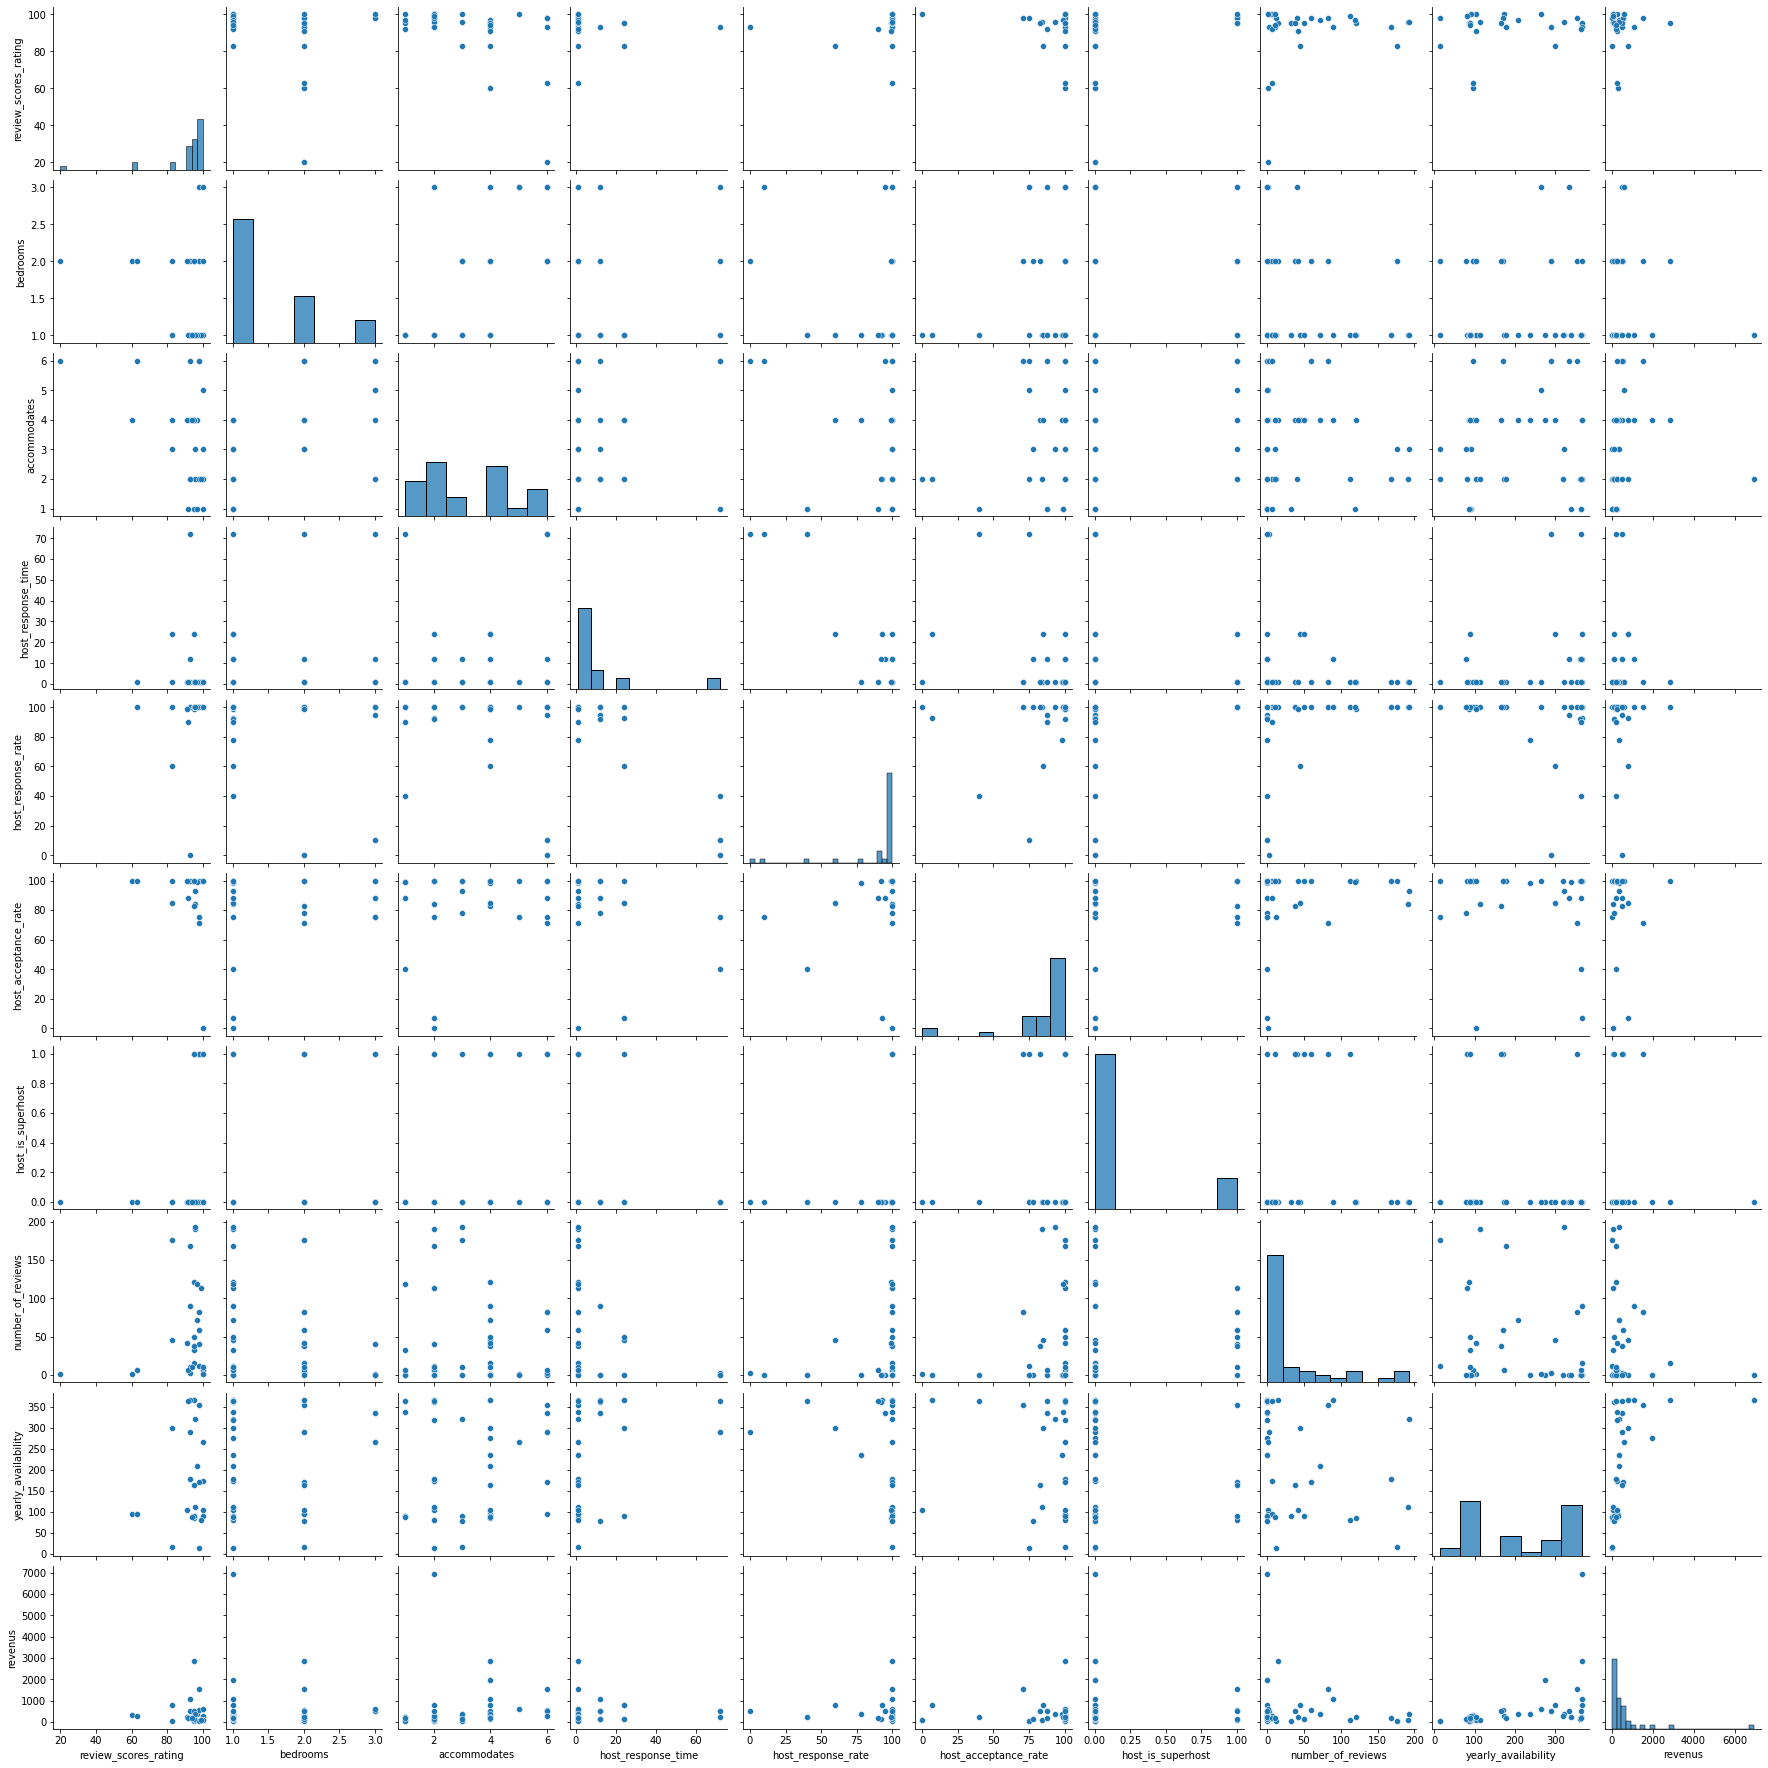

In [48]:
sns.pairplot(data[['review_scores_rating', 'bedrooms', 'accommodates', 'host_response_time', 'host_response_rate', 
'host_acceptance_rate', 'host_is_superhost', 
'number_of_reviews', 'yearly_availability', 'revenus']].sample(50))

In [45]:
data.loc[:,['bedrooms', 'accommodates', 'host_response_time', 'host_response_rate', 
'host_acceptance_rate', 'host_is_superhost', 
'number_of_reviews', 'yearly_availability', 'revenus']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17747 entries, 0 to 17746
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bedrooms              17747 non-null  float64
 1   accommodates          17747 non-null  int64  
 2   host_response_time    10042 non-null  float64
 3   host_response_rate    10042 non-null  float64
 4   host_acceptance_rate  9942 non-null   float64
 5   host_is_superhost     17268 non-null  float64
 6   number_of_reviews     17747 non-null  int64  
 7   yearly_availability   13190 non-null  float64
 8   revenus               13190 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 1.2 MB


In [ ]:
Les 